# Using Drago for Distributionally Robust Learning

In this tutorial, we show how to fit models using Drago (and baselines). Please see `README.md` for environment setup and other instructions.

In [22]:
from src.utils import get_objective, get_optimizer
from src.data import load_dataset
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

The two components required are an `Objective` (representing spectral risk measures or Chi-Squared divergence) and an `Optimizer`.

In [23]:
# Load a dataset, one of either: 'yacht', 'energy', 'concrete', 'kin8m', 'power', 'acsincome', 'diabetes', 'amazon', or 'iwildcam'.
# The smaller UCI and OpenML datasets will be downloaded automatically to the /data folder, whereas the larger ones require pre-downloading (See `README.md`).
dataset = "yacht"

X_train, y_train, X_val, y_val = load_dataset(dataset)

Specify the primal regularization constant with `l2_reg` and dual regularization constant with `shift_cost`.

In [24]:
# Build objective.
model_cfg = {
    "objective": "cvar", # Options: 'cvar', 'chi2',
    "l2_reg": 1.0,
    "loss": "squared_error",  # Options: 'squared_error', 'binary_cross_entropy', 'multinomial_cross_entropy'.
    "n_class": None,
    "shift_cost": 1.0,
}

train_obj = get_objective(model_cfg, X_train, y_train)
val_obj   = get_objective(model_cfg, X_val, y_val)

Generate the optimizer. The `drago_batch` variant uses $n/d$ as the batch/block size.

In [25]:
# Build optimizer.
seed = 1
optim_cfg = {
    "optimizer": "drago_batch", # Options: 'sgd', 'lsvrg', 'drago', 'drago_auto', 'drago_batch
    "lr": 0.0003,
    "epoch_len": 200, # Used as an update interval for LSVRG, and otherwise is simply a logging interval for other methods.
    "shift_cost": 1.0,
}
optimizer = get_optimizer(optim_cfg, train_obj, seed)

In [26]:
n_epochs = 64

train_losses = []
val_losses = []
epoch_len = optimizer.get_epoch_len()
for epoch in tqdm(range(n_epochs)):

    optimizer.start_epoch()
    for _ in range(epoch_len):
        optimizer.step()
    optimizer.end_epoch()

    # The current iterate can be accessed with optimizer.weights, 
    # and the full-batch loss can be computed with objective.get_batch_loss.
    train_losses.append(train_obj.get_batch_loss(optimizer.weights).item())
    val_losses.append(val_obj.get_batch_loss(optimizer.weights).item())

100%|██████████| 64/64 [00:08<00:00,  7.64it/s]


We use a second-order optimizer as a reference to measure suboptimality.

In [27]:
# compare to a reference loss from L-BFGS (second-order method)
train_obj_ = get_objective(model_cfg, X_train, y_train)

# Define function and Jacobian oracles.
def fun(w):
    return train_obj_.get_batch_loss(torch.tensor(w, dtype=torch.float64)).item()

def jac(w):
    return (
        train_obj_.get_batch_subgrad(
            torch.tensor(w, dtype=torch.float64, requires_grad=True)
        )
        .detach()
        .numpy()
    )

# Run optimizer.
d = train_obj.d
init = np.zeros((d,), dtype=np.float64)
if model_cfg["n_class"]:
    init = np.zeros((model_cfg["n_class"] * d,), dtype=np.float64)
else:
    init = np.zeros((d,), dtype=np.float64)
output = minimize(fun, init, method="L-BFGS-B", jac=jac)
if output.success:
    print(f"L-BGFS sucsess! Minimum loss on {dataset}: {output.fun:0.4f}")
else:
    raise Exception(output.message)

L-BGFS sucsess! Minimum loss on yacht: 0.7561


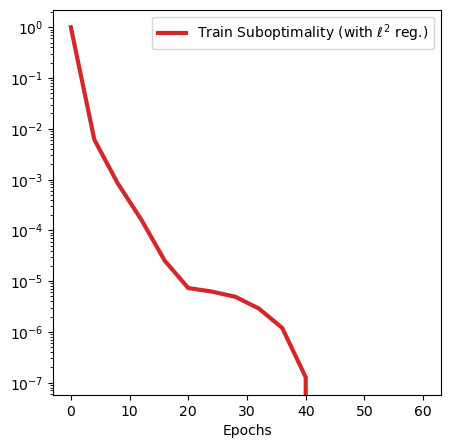

In [28]:
# Display training and validation loss.

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

t = np.arange(len(train_losses))

minimum_loss = output.fun
train_losses = np.array(train_losses)
subopt = (train_losses - minimum_loss) / (train_losses[0] - minimum_loss)

downsample = 4
ax.plot(t[::downsample], subopt[::downsample], color="tab:red", linewidth=3, label=r"Train Suboptimality (with $\ell^2$ reg.)")
ax.set_xlabel("Epochs")

ax.legend()
ax.set_yscale("log")
plt.show()